In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron_model import *
from scipy.signal import argrelmax, argrelmin

In [2]:
def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

def neg_conductance_range(i, v):
    max_idx = argrelmax(i)[0] # Local max
    min_idx = argrelmin(i)[0] # Local min
    
    if (not max_idx.shape[0]) | (not min_idx.shape[0]):
        print("No negative conductance.", end='')
        return None
    else:
        print(f"negative conductance range: ({v[max_idx[0]]:.2f}V, {v[min_idx[0]]:.2f}V)", end='')
        return (v[max_idx[0]], v[min_idx[0]])

def neuromod_slow_neg(neuron_number, scale_by, slow_neg_conductances):
    if type(neuron_number) == int:
        neuron_number = list(neuron_number)
        
    for elt in neuron_number:
        this_conductance = slow_neg_conductances[elt - 1]
        if this_conductance:
            old_a = this_conductance.a
            this_conductance.update_a(old_a * scale_by)
            print(f"Neuron #{elt} new a:", this_conductance.a)

# Simple neuron

In [19]:
# Create neuron
neuron = Neuron(seed=0)

# Set timescales
tf = 0.1 
ts = 20
tus = ts**2

R = neuron.add_conductance(1, E_rev = 0) # Add leak 1, 0

# Set gains and reversal potentials

# Fast
a_neg_f_init = -2 # -2
voff_neg_f_init = 0 # 0

# Slow
a_pos_s_init = 2 # 2
voff_pos_s_init = 0 # 0
a_neg_s_init = -1.5 # -1.5
voff_neg_s_init = -0.9 # -0.9

# Ultra slow
a_pos_us_init = 1.5 # 1.5
voff_pos_us_init = -0.9 # -0.9

# Add currents
i1 = neuron.add_current(a_neg_f_init, voff_neg_f_init, tf)
i2 = neuron.add_current(a_pos_s_init, voff_pos_s_init, ts)
i3 = neuron.add_current(a_neg_s_init, voff_neg_s_init, ts)
i4 = neuron.add_current(a_pos_us_init, voff_pos_us_init, tus)

# Change temp
dotemp = True
temp = 15
if dotemp:
    neuron.update_temp(temp)

Spike: negative conductance range: (-1.00V, 1.00V) => Iapp: (-0.71A, 0.71A)
Burst: negative conductance range: (-1.60V, 0.10V) => Iapp: (-1.25A, 0.06A)


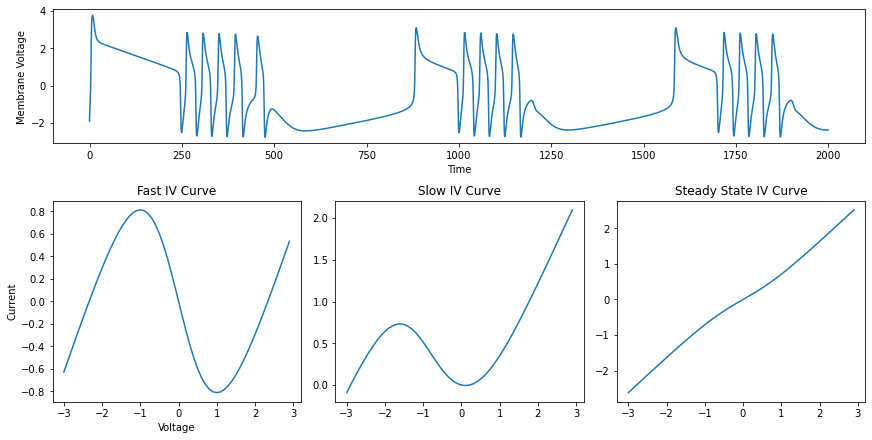

In [20]:
trange = (0, 2000) # time length of simulation

# Scale conductances
scl_s = 1 # Scale slo pos neg conductances in proportion to incrs intraburst freq.
scl_us = 1 # Scale ultraslo to increase interburst freq.

i2.update_a(a_pos_s_init * scl_s)
i3.update_a(a_neg_s_init * scl_s)
i4.update_a(a_pos_us_init * scl_us)

I0 = -0.55 # Adjust to put the neuron in different states
i_app = lambda t: I0 # Iapp(t)

# Get IV curves
V = np.arange(-3, 3, 0.1)

If = neuron.IV(V, tf)
Is = neuron.IV(V, ts)
Iss = neuron.IV_ss(V)
currents = [If, Is]
for i, elt in enumerate(["Spike: ", "Burst: "]):
    print(elt, end='')
    crit_range = neg_conductance_range(currents[i], V)
    if crit_range:
        i_app_start, i_app_end = neuron.IV_ss(crit_range[0]), neuron.IV_ss(crit_range[1])
        print(f" => Iapp: ({i_app_start:.2f}A, {i_app_end:.2f}A)")
        
sol = neuron.simulate(trange, i_app) # call neuron's simulate functionality

# Lay out plot
fig = plt.figure(figsize=(12,6), constrained_layout=True)
spec = fig.add_gridspec(nrows=2, ncols=3, height_ratios=(1, 1.5))
ax1 = fig.add_subplot(spec[0,:])
ax2 = fig.add_subplot(spec[1,0:1])
# ax3 = fig.add_subplot(spec[1,1:2], sharex=ax2, sharey=ax2)
# ax4 = fig.add_subplot(spec[1,2:], sharex=ax2, sharey=ax2)
ax3 = fig.add_subplot(spec[1,1:2])
ax4 = fig.add_subplot(spec[1,2:])

# Label plot
ax2.set_title("Fast IV Curve")
ax3.set_title("Slow IV Curve")
ax4.set_title("Steady State IV Curve")

ax1.set_ylabel("Membrane Voltage")
ax1.set_xlabel("Time")
ax2.set_ylabel("Current")
ax2.set_xlabel("Voltage")

# Plot
ax1.plot(sol.t, sol.y[0])
ax2.plot(V, If)
ax3.plot(V, Is)
ax4.plot(V, Iss)
plt.show()

In [174]:
# Modeling redundancy
'''
To do:

Make functions to find local min/max of IV curves to get spiking ranges, bursting ranges
Use IV_ss to generate the Iapp necessary to get in those ranges
Try redundancy, first with exact copies, then with some noise around the parameters - gain and tau
Try perturbing redundant and non redundant models
'''

In [24]:
copycat = deepcopy(neuron)
i5 = neuron.add_current(3, 0, 60)

1.5507979025745755 1.9670298390136767


neuron_model.Neuron.CurrentElement